Import Libraries


In [ ]:
# Install dependencies
!pip install tensorflow numpy matplotlib opencv-python

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,precision_recall_curve,
                             accuracy_score, precision_score, recall_score, auc,
                             f1_score, roc_auc_score, roc_curve, precision_recall_fscore_support)

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (BaggingClassifier, RandomForestClassifier,
                              AdaBoostClassifier, GradientBoostingClassifier,
                              VotingClassifier, StackingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras import layers, models

# 1. Initialize the Brain
model = models.Sequential()

# 2. The "Eyes" (Convolutional Layers)
# Look for 32 different features (edges/shapes) using a 3x3 filter
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2))) # Shrink the image (focus on what matters)

# Look for 64 more complex features
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# 3. The "Thinking" (Dense Layers)
model.add(layers.Flatten()) # Flatten the 2D image into a 1D list of numbers
model.add(layers.Dense(64, activation='relu')) # A layer of neurons to think

# 4. The Output
# 1 neuron. If output is near 0 -> Healthy. If near 1 -> Cancer.
model.add(layers.Dense(4, activation='sigmoid'))#1 is for 2 categories, 4 is for 4 categories)

Import Dataset


In [3]:
import tensorflow as tf
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

file_list = os.listdir(path)
print("Files in folder:", file_list)

# 1. Setup variables (Constraints)
# We resize everything to 150x150 so the CNN doesn't get confused by different sizes.
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32  # The AI learns from 32 images at a time

# 2. Load the 'Training' Data
print("Loading Training Data:")
train = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/brain-tumor-mri-dataset/Training',        # Point to the folder
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical',   # Use 'categorical' because you have 4 folder types
    shuffle=True                # Shuffle so the AI doesn't memorize the order
)

# 3. Load the 'Testing' Data (Validation)
print("\nLoading Testing Data:")
test = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/brain-tumor-mri-dataset/Testing',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)

# 4. Check the class names (The folders it found)
class_names = train.class_names
print(f"\nClasses found: {class_names}")

Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
Path to dataset files: /kaggle/input/brain-tumor-mri-dataset
Files in folder: ['Training', 'Testing']
Loading Training Data:
Found 5712 files belonging to 4 classes.

Loading Testing Data:
Found 1311 files belonging to 4 classes.

Classes found: ['glioma', 'meningioma', 'notumor', 'pituitary']


Load Model( Scroll down to Testing to see accuracy )


In [15]:
model = tf.keras.models.load_model(
        '/content/mri_tumor_detector.keras',
        compile=False  # Skip compilation
    )
print("✓ Model loaded without compilation!")

    # Recompile manually
model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',  # or 'binary_crossentropy'
        metrics=['accuracy']
    )
print("✓ Model recompiled!")
model.summary()


✓ Model loaded without compilation!
✓ Model recompiled!


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,868 (18.42 MB)

 Trainable params: 4,828,868 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

Pre-trained model test:

In [4]:
# 1. Define data augmentation FIRST
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomBrightness(0.2),
    layers.RandomContrast(0.2),
])

# 2. Choose ONE model approach - Transfer Learning (recommended)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(150, 150, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze pre-trained weights initially

model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(4, activation='softmax')
])

# 3. Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 4. Set up callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7
)

# 5. Train
history = model.fit(
    train,
    validation_data=test,
    epochs=30,
    callbacks=[reduce_lr]
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 34s 133ms/step - accuracy: 0.4354 - loss: 1.4093 - val_accuracy: 0.5507 - val_loss: 1.0349 - learning_rate: 0.0010
Epoch 2/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.5707 - loss: 0.9954 - val_accuracy: 0.5698 - val_loss: 0.9875 - learning_rate: 0.0010
Epoch 3/30
124/179 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.5851 - loss: 0.9529


KeyboardInterrupt



Train


In [5]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal", input_shape=(150, 150, 3)),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
])

model = models.Sequential([
  # 1. The Augmentation Block (New!)
  data_augmentation,

  # 2. Convolution Layer 1
  layers.Conv2D(32, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),

  # 3. Convolution Layer 2
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),

  # 4. Convolution Layer 3 (Added for more depth)
  layers.Conv2D(128, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),

  # 5. Flatten & Dense
  layers.Flatten(),
  layers.Dropout(0.5),  # <--- DROPOUT: Kills 50% of neurons randomly to prevent memorization
  layers.Dense(128, activation='relu'),

  # 6. Output (4 classes)
  layers.Dense(4, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train for a bit longer since the problem is harder now
history = model.fit(train, validation_data=test, epochs=15)

Epoch 1/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - accuracy: 0.4839 - loss: 15.3070 - val_accuracy: 0.6766 - val_loss: 0.8188
Epoch 2/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - accuracy: 0.6938 - loss: 0.7780 - val_accuracy: 0.7468 - val_loss: 0.7661
Epoch 3/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.7349 - loss: 0.6643 - val_accuracy: 0.7117 - val_loss: 0.6431
Epoch 4/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.7679 - loss: 0.5904 - val_accuracy: 0.7597 - val_loss: 0.5913
Epoch 5/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.7941 - loss: 0.5253 - val_accuracy: 0.7887 - val_loss: 0.5109
Epoch 6/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.8013 - loss: 0.5034 - val_accuracy: 0.7925 - val_loss: 0.4974
Epoch 7/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.8175 - loss: 0.4852 - val_accuracy: 0.7750 - val_loss: 0.5803
Epoch 8/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.8255 - loss: 0.4494 -

Test


In [16]:
# Evaluate the model on the test data
print("Evaluating model...")
test_loss, test_acc = model.evaluate(test)

print(f"\nTest Accuracy: {test_acc * 100:.2f}%")

Evaluating model...
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6994 - loss: 0.7217

Test Accuracy: 82.91%


Generating predictions for Confusion Matrix...


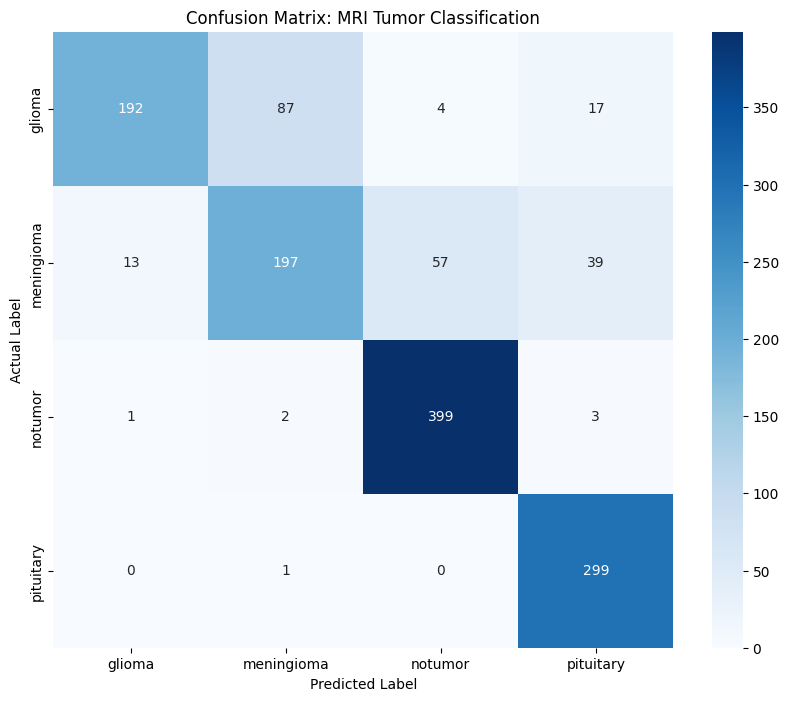


Classification Report:
              precision    recall  f1-score   support

      glioma       0.93      0.64      0.76       300
  meningioma       0.69      0.64      0.66       306
     notumor       0.87      0.99      0.92       405
   pituitary       0.84      1.00      0.91       300

    accuracy                           0.83      1311
   macro avg       0.83      0.82      0.81      1311
weighted avg       0.83      0.83      0.82      1311



In [18]:
print("Generating predictions for Confusion Matrix...")

# 1. Collect True Labels and Predictions
true_labels = []
predicted_labels = []

# Iterate through the test dataset
# Note: We extract them batch by batch to ensure the images match the labels
for images, labels in test:
    # Make predictions on the batch
    preds = model.predict(images, verbose=0)

    # Convert the raw probabilities (softmax) to class indices (0, 1, 2, 3)
    pred_classes = np.argmax(preds, axis=1)

    # Convert one-hot encoded true labels to indices
    # (Since you used categorical_crossentropy, labels are one-hot)
    true_classes = np.argmax(labels.numpy(), axis=1)

    predicted_labels.extend(pred_classes)
    true_labels.extend(true_classes)

# Convert to numpy arrays for efficient computation
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# 2. Define Class Names
# Ensure this matches the exact alphabetical order of your folders
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# 3. Create the Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)

# 4. Plot the Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix: MRI Tumor Classification')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# 5. Print Detailed Report (Optional but highly recommended for LinkedIn)
# This gives you Precision, Recall, and F1-Score for each tumor type
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

Random Test


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


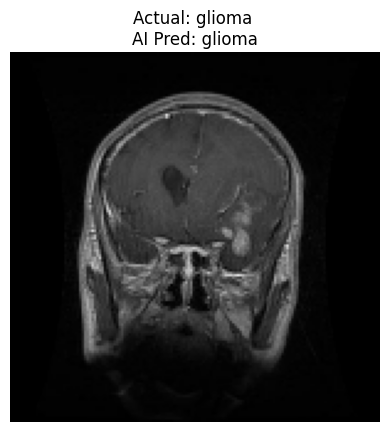

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# --- THE FIX: Chain .shuffle() before .take() ---
# buffer_size=1000 means "mix up 1000 images before picking a batch"
for images, labels in test.shuffle(1000).take(1):

    # 1. Pick a RANDOM index from this batch (instead of always index 0)
    # 'images' usually has 32 items. We pick a random number between 0 and 31.
    random_index = np.random.randint(0, len(images))

    # 2. Grab that specific random image
    img = images[random_index].numpy().astype("uint8")
    actual_label_index = np.argmax(labels[random_index])

    # 3. Predict
    img_prediction = tf.expand_dims(images[random_index], 0)
    predictions = model.predict(img_prediction)
    predicted_label_index = np.argmax(predictions)

    # 4. Show result
    plt.imshow(img)
    plt.title(f"Actual: {class_names[actual_label_index]} \nAI Pred: {class_names[predicted_label_index]}")
    plt.axis("off")
    plt.show()

    break

Save Model

In [ ]:
# Save the entire model as a single file
model.save('mri_tumor_detector.keras')
print("Model saved! Check your file browser on the left.")

Model saved! Check your file browser on the left.


In [ ]:
# Save as legacy .h5 format which allows us to strip the optimizer easily
# include_optimizer=False -> Throws away the heavy "training history"
model.save('neurovision_model.h5', save_format='h5', include_optimizer=False)

print("Optimized model saved as 'neurovision_model.h5'")

Optimized model saved as 'neurovision_model.h5'
